In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from functools import partial
from tqdm import tqdm

import meshes as ms
from meshes.mesh import StructuredMeshNetwork
from meshes.crossing import Crossing, MZICrossing
from meshes.jax import dot

import CasOptAx as conn
from CasOptAx.linear_optics import Linear_Optics
from CasOptAx.circuit_builder import Circuit_singlemode
from CasOptAx.meshes_utils import Prunable_SCF

C code in meshes/c not compiled (run makefile to compile), falling back to Numba.


c:\Users\jasvith\Desktop\Code\CasOptAx\meshes_utils.py:20: UserWarning: Please make sure the meshes package is imported. To import the meshes package, git clone https://github.com/QPG-MIT/meshes.git
  warnings.warn("Please make sure the meshes package is imported. To import the meshes package, git clone https://github.com/QPG-MIT/meshes.git")


In [2]:
import jax
from jax import jit
import jax.numpy as jnp
from jax import flatten_util
import pickle

from scipy.stats import entropy

In [3]:
N_photons = 6
N_modes = 8

lo = Linear_Optics(N_modes)
with open('circ_class_6_photons_8_modes.pickle', 'rb') as handle:
    circ = pickle.load(handle)


init_state = circ.state_amps.copy()
# circ.visualize_state(init_state)
# Make the bell states
zero_state = {list(init_state.keys())[i]: 0 + 0j for i in range(circ.num_possible_states)}

phi_plus = zero_state.copy()
phi_plus[(1, 0, 1, 0, 1, 1, 1, 1)] = 1/np.sqrt(2)
phi_plus[(0, 1, 0, 1, 1, 1, 1, 1)] = 1/np.sqrt(2)

phi_minus = zero_state.copy()
phi_minus[(1, 0, 1, 0, 1, 1, 1, 1)] = 1/np.sqrt(2)
phi_minus[(0, 1, 0, 1, 1, 1, 1, 1)] = -1 * 1/np.sqrt(2)

psi_plus = zero_state.copy()
psi_plus[(1, 0, 0, 1, 1, 1, 1, 1)] = 1/np.sqrt(2)
psi_plus[(0, 1, 1, 0, 1, 1, 1, 1)] = 1/np.sqrt(2)

psi_minus = zero_state.copy()
psi_minus[(1, 0, 0, 1, 1, 1, 1, 1)] = 1/np.sqrt(2)
psi_minus[(0, 1, 1, 0, 1, 1, 1, 1)] = -1 * 1/np.sqrt(2)

In [4]:
def linear_evolution(circ, state_amps, U):
    r"""
    Slightly modified version of circ.linear_evolution to avoid reconstructing the pytree

    :param circ: Circuit object containing state indices and factorial precomputations
    :param state_amps: Probability amplitudes of the states being input into the mesh
    :param U: Unitary matrix representing the transformation
    :return: Output probability amplitudes of all the states, maintaining pytree structure
    """
    weights = U.astype(jnp.complex64)  # Ensure the dtype is suitable for complex operations

    def transform_single_state(amp, states_array, states_factorial):
        return bosonic_transform(amp, weights, states_array, states_factorial)

    # Direct tree map application without flattening/unflattening unnecessarily
    new_amps = jax.tree_util.tree_map(transform_single_state, state_amps, circ.all_states_idx, circ.all_states_factorial)

    # Efficient summation using tree_reduce
    def sum_tree_leaves(tree):
        return jax.tree_util.tree_reduce(lambda a, b: a + b, tree)

    return sum_tree_leaves(new_amps)

@partial(jit, static_argnums=(0,))
def bosonic_transform(amp, U, states_array_idx, states_array_factorial):
    r"""
    Correspondingly updated funtion to support the linear_evolution function

    :param amp: Probability amplitude of a given state, as passed via tree_map from add_linear_layer
    :param U: Unitary matrix weights, typically matrix implemented by MZI mesh derived from theta, phi, D, alpha, beta passed to add_linear_layer
    :param states_array_idx: Indices of states to extract sub-matrix U_st from matrix U
    :param states_array_factorial: product of factorial of corresponding states
    :return: Pytree (structure of self.possible_states_dict) of how every state maps to every other state
    """
    def make_U_st(U, idx_array):
        r"""
        Make U_st matrix from U - m_{k} copies of the k^{th} input state column and n_{k} copies of the k^{th} output state row

        :param U: Matrix to calculate the sub-matrices
        :param idx_array: Indices corresponding to the m_{k} and n_{k} states, generated in self.all_states_idx
        :return: submatrix U_{st}
        """
        idx_x, idx_y = idx_array[0], idx_array[1]
        return U[:, idx_x][idx_y]

    U_st = jax.vmap(lambda idx_val: make_U_st(U, states_array_idx[idx_val]))(circ.arange_possible_states)
    perm_vals = jax.vmap(lambda idx: circ.lo.calc_perm(U_st[idx]))(circ.arange_possible_states)
    new_amps = amp * perm_vals / jnp.sqrt(states_array_factorial)
    return new_amps

In [5]:
N_photons, N_modes = 6, 8

lo = Linear_Optics(N_modes)
U = jnp.eye(N_modes, dtype='bfloat16')
test_out_state = %time linear_evolution(circ, init_state, U)

CPU times: total: 14.5 s
Wall time: 2.88 s


In [6]:
prior_prob_of_input = jnp.array([0.25, 0.25, 0.25, 0.25])
bell_states = [phi_plus, phi_minus, psi_plus, psi_minus]
IDK_threshold = 0.6

def calc_success_prob(U, IDK_threshold):
  output_conditional_probs = jnp.zeros((4, circ.num_possible_states))
  output_conditional_probs_withIDK = np.zeros((5, circ.num_possible_states))
  out_state_array = np.zeros((4, circ.num_possible_states)) + 0j
  for idx, bell_state in enumerate(bell_states):
    out_state = linear_evolution(circ, bell_state, U)
    out_state_array[idx] = out_state
    output_conditional_probs = output_conditional_probs.at[idx].set(jnp.abs(jnp.array(out_state))**2 * prior_prob_of_input[idx])

  Decision_judge_Matrix = (output_conditional_probs)/(jnp.sum(output_conditional_probs + 1e-15, axis = 0))

  # Create a mask where Decision_judge_Matrix is below the threshold
  mask = Decision_judge_Matrix[:4, :] < IDK_threshold

  # Use NumPy operations to update the array efficiently
  output_conditional_probs_withIDK[:4, :][mask] = 0
  output_conditional_probs_withIDK[4, :] += np.sum(output_conditional_probs[:4, :] * mask, axis=0)
  output_conditional_probs_withIDK[:4, :][~mask] = output_conditional_probs[:4, :][~mask]

  P_success_withIDK= 1 - np.sum(output_conditional_probs_withIDK[4]) #Success probability to get a yield
  P_errorWhenSuccess_withIDK= 1-np.sum(np.max(output_conditional_probs_withIDK, axis = 0)) #Probability of a success yield cause error
  Entropy_WhenSucess_withIDK= np.maximum((1 - entropy(Decision_judge_Matrix + 1e-15, axis = 0,base = 2)), np.zeros(circ.num_possible_states)) @ np.sum(output_conditional_probs_withIDK[0:4], axis = 0) #Bell-state entropy rate, as decribed the 2nd way below.

  return P_success_withIDK, P_errorWhenSuccess_withIDK, Entropy_WhenSucess_withIDK, out_state_array



In [7]:
SCF_pruned = Prunable_SCF(N = N_modes, M = ms.haar_mat(N_modes), stride_vals = np.array([1, 2, 4]))

stride_1_phases = np.array([jnp.pi, 0] * (N_modes//4) + [jnp.pi/2, 0] * (N_modes//4))
stride_2_phases = np.array([jnp.pi/2, 0] * (N_modes//4) + [jnp.pi, 0] * (N_modes//4))
stride_4_phases = np.array([jnp.pi/2, 0] * (N_modes//2))
phase_screen = np.array([0] * (N_modes))

dummy_stride_phases = np.array([jnp.pi, 0] * (N_modes//2))
phases_dict = {1: stride_1_phases, 2: stride_2_phases, 4: stride_4_phases}

stride_array = np.array([1, 2, 4])
SCF_full = Prunable_SCF(N = N_modes, M = jnp.eye(N_modes) + 0j, stride_vals = stride_array)

def make_phases(stride_array):
  stride_check, stride_phases = [], []
  for idx, s in enumerate(stride_array):
    if s not in stride_check:
      stride_check.append(s)
      # stride_phases = np.concatenate(stride_phases, phases_dict[s])
      stride_phases.extend(phases_dict[s])
    else:
      # stride_phases = np.concatenate(stride_phases, dummy_stride_phases)
      stride_phases.extend(dummy_stride_phases)
  stride_phases.extend(phase_screen)
  return np.array(stride_phases)

# stride_phases = np.array(stride_phases)
stride_phases = make_phases(stride_array)
print (stride_phases.shape)
np.round(SCF_full.matrix(p_phase = stride_phases), 3)

(32,)


array([[-0.+0.5j, -0.+0.j , -0.+0.5j, -0.+0.j , -0.+0.5j, -0.+0.5j,
        -0.+0.j , -0.+0.j ],
       [-0.+0.j ,  0.-0.5j, -0.+0.j ,  0.-0.5j, -0.+0.5j,  0.-0.5j,
        -0.+0.j ,  0.-0.j ],
       [-0.+0.5j, -0.+0.j ,  0.-0.5j,  0.-0.j , -0.+0.j , -0.+0.j ,
         0.-0.5j,  0.-0.5j],
       [-0.+0.j ,  0.-0.5j,  0.-0.j , -0.+0.5j, -0.+0.j ,  0.-0.j ,
         0.-0.5j, -0.+0.5j],
       [-0.+0.5j, -0.+0.j , -0.+0.5j, -0.+0.j ,  0.-0.5j,  0.-0.5j,
         0.-0.j ,  0.-0.j ],
       [-0.+0.j ,  0.-0.5j, -0.+0.j ,  0.-0.5j,  0.-0.5j, -0.+0.5j,
         0.-0.j , -0.+0.j ],
       [-0.+0.5j, -0.+0.j ,  0.-0.5j,  0.-0.j ,  0.-0.j ,  0.-0.j ,
        -0.+0.5j, -0.+0.5j],
       [-0.+0.j ,  0.-0.5j,  0.-0.j , -0.+0.5j,  0.-0.j , -0.+0.j ,
        -0.+0.5j,  0.-0.5j]])

In [8]:
%time calc_success_prob(SCF_full.matrix(p_phase = stride_phases), IDK_threshold)

CPU times: total: 58.8 s
Wall time: 11.6 s


(0.7500000316649675,
 9.615905582904816e-08,
 0.7499999355059117,
 array([[ 1.11157721e-33+0.0000000e+00j,  2.08664033e-38+0.0000000e+00j,
         -2.86999379e-34+0.0000000e+00j, ...,
          6.80687783e-33+1.5374821e-34j, -1.59343442e-38+0.0000000e+00j,
         -1.11157639e-33+0.0000000e+00j],
        [-1.11157721e-33+0.0000000e+00j, -2.08664033e-38+0.0000000e+00j,
          8.61007735e-34+0.0000000e+00j, ...,
          6.80687783e-33+1.5374821e-34j, -1.59343442e-38+0.0000000e+00j,
         -1.11157639e-33+0.0000000e+00j],
        [ 0.00000000e+00+0.0000000e+00j, -9.07589913e-34+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
         -7.04804463e-24+0.0000000e+00j,  9.07587525e-34+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j],
        [ 0.00000000e+00+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j, ...,
          8.54308435e-24+0.0000000e+00j,  0.00000000e+00+0.0000000e+00j,
          0.00000000e+00+0.0000000e+00j]

In [9]:
possible_strides = [2**i for i in range(0, int(np.log2(N_modes)))]

def make_gm_errors(N, sigma, stride_array):
  err_vals_stride = np.random.normal(0, sigma, size = 1)
  err_stride_dict = {}
  for i in range(len(possible_strides)):
    err_stride_dict[possible_strides[i]] = err_vals_stride[0] #index 0 if only 1 MZI, i of log2N MZIs
  return np.array([np.ones(N//2) * err_stride_dict[s] for s in stride_array]).flatten()

# make_gm_errors(16, 0.01)
alpha_err_gm = make_gm_errors(N_modes, 0.01, stride_array)
beta_err_gm = make_gm_errors(N_modes, 0.01, stride_array)
err_gm = np.array([alpha_err_gm, beta_err_gm]).T

In [17]:
sigma_val = 0.01
N_modes = 8
ct = 5
IDK_threshold = 0.6

stride_array = {3: [1, 2, 4], 4: [1, 2, 1, 4], 5: [1, 2, 1, 4, 1], 6: [1, 2, 1, 4, 1, 2], 7: [1, 2, 1, 4, 1, 2, 1]}
# stride_array = {7: [1, 2, 1, 4, 1, 2, 1]}
P_success_withIDK_array = np.zeros((5, ct))
P_errorWhenSuccess_withIDK_array = np.zeros((5, ct))
Entropy_WhenSucess_withIDK_array = np.zeros((5, ct))
out_states_array = np.zeros((len(stride_array.keys()), ct, 4, circ.num_possible_states)) + 0j

for idx, s_len in enumerate(list(stride_array.keys())):
  print (f'Running for stride length: {s_len}')
  s_array = stride_array[s_len]
  trunc = Prunable_SCF(N = N_modes, M = ms.haar_mat(N_modes), stride_vals = s_array)
  stride_phases = make_phases(s_array)
  for jdx in (range(ct)):
    alpha_err_gm = make_gm_errors(N_modes, sigma_val, s_array)
    beta_err_gm = make_gm_errors(N_modes, sigma_val, s_array)
    err_gm = np.array([alpha_err_gm, beta_err_gm]).T
    P_success_withIDK, P_errorWhenSuccess_withIDK, Entropy_WhenSucess_withIDK, out_states = calc_success_prob(trunc.matrix(p_phase = stride_phases, p_splitter = err_gm), IDK_threshold)
    print (f'Epoch: {jdx}, Success Probability: {P_success_withIDK}, Error Probability: {P_errorWhenSuccess_withIDK}, Entropy: {Entropy_WhenSucess_withIDK}')
    P_success_withIDK_array[idx, jdx] = P_success_withIDK
    P_errorWhenSuccess_withIDK_array[idx, jdx] = P_errorWhenSuccess_withIDK
    Entropy_WhenSucess_withIDK_array[idx, jdx] = Entropy_WhenSucess_withIDK
    out_states_array[idx, jdx] = out_states

Running for stride length: 3
Epoch: 0, Success Probability: 0.7497530894820448, Error Probability: 0.00024753774574781673, Entropy: 0.7467140324131638
Epoch: 1, Success Probability: 0.7495334422014712, Error Probability: 0.0004669893083061316, Entropy: 0.7441395701718049
Epoch: 2, Success Probability: 0.7499279742402789, Error Probability: 7.268832996043528e-05, Entropy: 0.7489431727740281
Epoch: 3, Success Probability: 0.7496983329907587, Error Probability: 0.00030176632121658997, Entropy: 0.7462765093523648
Epoch: 4, Success Probability: 0.7476860987138121, Error Probability: 0.0023135852061318962, Entropy: 0.7268277719484957
Running for stride length: 4
Epoch: 0, Success Probability: 0.7499510035707229, Error Probability: 4.955345518031784e-05, Entropy: 0.7493542416717183
Epoch: 1, Success Probability: 0.7497785678595301, Error Probability: 0.00022173288327986818, Entropy: 0.7471983992922722
Epoch: 2, Success Probability: 0.7498709978902283, Error Probability: 0.00012979015897773838

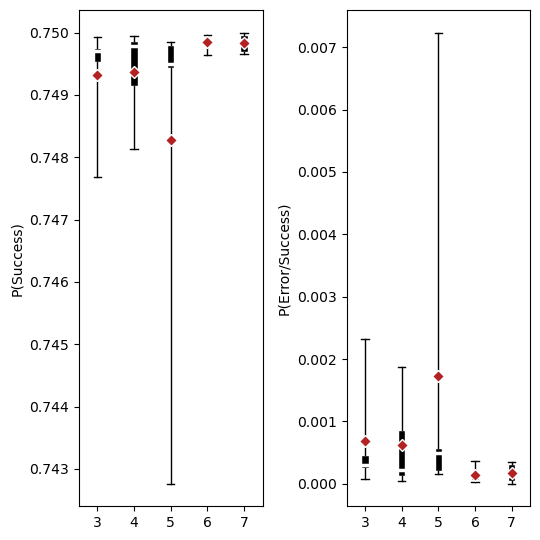

In [18]:
def make_boxplot(ax, data, x_position):
  # ax.set_xlim(0.00, 0.11)
  ax.boxplot(data, positions = [np.round(x_position, 3)], whis = 1000, widths = 0.2, showmeans = True, capwidths = 0.2, patch_artist=True, boxprops={'facecolor': 'black', 'edgecolor': 'white'},
            medianprops = {"color": "white", "linewidth": 2.5}, meanprops = {'marker': 'D', 'markeredgecolor': 'white', 'markerfacecolor': 'firebrick'})

fig, ax = plt.subplots(1, 2, figsize = (5.5, 5.5))
for idx, data in enumerate(P_success_withIDK_array):
  make_boxplot(ax[0], data, list(stride_array.keys())[idx])
ax[0].set_ylabel('P(Success)')
# ax[0].set_xticklabels(np.round(sigma_vals, 3), fontsize = 7)

for idx, data in enumerate(P_errorWhenSuccess_withIDK_array):
  make_boxplot(ax[1], data, list(stride_array.keys())[idx])
ax[1].set_ylabel('P(Error/Success)')

fig.tight_layout()